In [1]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2020-11-25 03:25:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   201MB/s    in 0.3s    

2020-11-25 03:25:40 (201 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
# 압축 풀기

In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
# 경로 지정하기

In [5]:
# 기본 경로 
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')

# 훈련에 사용되는 고양이/ 개 이미지 경로 
train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 테스트에 사용되는 고양이 / 개 이미지 경로
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')
print(validation_cats_dir)
print(validation_dogs_dir)

/tmp/cats_and_dogs_filtered/train/cats
/tmp/cats_and_dogs_filtered/train/dogs
/tmp/cats_and_dogs_filtered/validation/cats
/tmp/cats_and_dogs_filtered/validation/dogs


In [6]:
# kaggle 의 데이터 셋 정보 추출

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)  # listdir 은 파일의 이름을 리스트의 형태로 반환
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:5])
print(train_dog_fnames[:5])

['cat.911.jpg', 'cat.392.jpg', 'cat.594.jpg', 'cat.81.jpg', 'cat.951.jpg']
['dog.186.jpg', 'dog.115.jpg', 'dog.255.jpg', 'dog.696.jpg', 'dog.401.jpg']


In [8]:
print('전체 트레이닝cats의 이미지:',len(os.listdir(train_cats_dir)))
print('전체 트레이닝dogs의 이미지:',len(os.listdir(train_dogs_dir)))

print('전체 테스트cats의 이미지 :', len(os.listdir(validation_cats_dir)))
print('전체 테스트dogs의 이미지 :', len(os.listdir(validation_dogs_dir)))

전체 트레이닝cats의 이미지: 1000
전체 트레이닝dogs의 이미지: 1000
전체 테스트cats의 이미지 : 500
전체 테스트dogs의 이미지 : 500


In [9]:
# 이미지 확인하기
%matplotlib inline

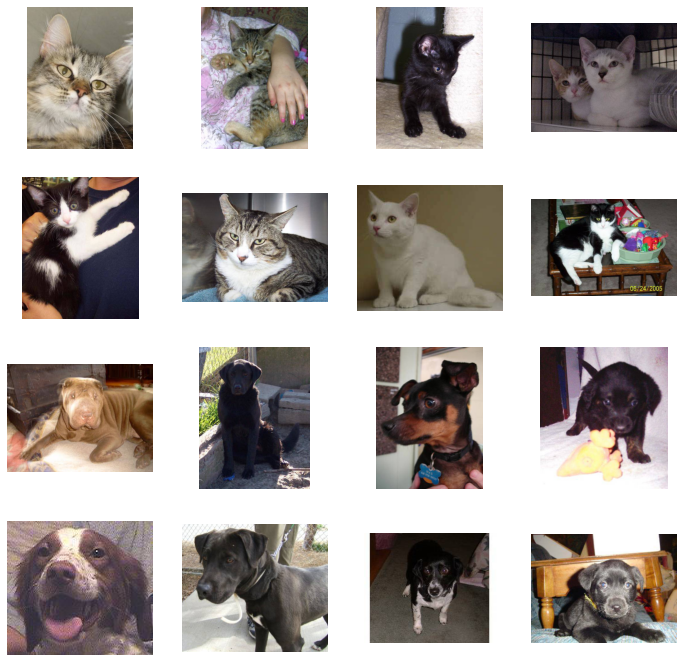

In [10]:


import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4,4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3,nrows*3)
pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir,fname)
                  for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir,fname)
                  for fname in train_dog_fnames[pic_index-8:pic_index]]     

for i , img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows,ncols,i+1)
  sp.axis('OFF')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()       

In [11]:
# 모델 구성하기 

In [12]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')  # 0,1 로 분류되는 binary 분류 문제에 적합.
])


model.summary()  # 신경망 구조 확인 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [13]:
from tensorflow.keras.optimizers import RMSprop  # rmsprop(Root Mean Square Propagation) 알고리즘은 훈련 과정 중에 학습률을 적절하게 변화시킨다.
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# 이미지 데이터 전처리 하기

# 훈련을 진행하기 전 tf.keras.preprocessing.image 모듈의 ImageDataGenerator 클래스를 이용해서 데이터 전처리를 진행

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale =  1.0/255.)
test_datagen = ImageDataGenerator(rescale =  1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size =20,
                                                    class_mode ='binary',
                                                    target_size = (150,150))

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = 20,
                                                        class_mode = 'binary',
                                                        target_size = (150,150))
# flow_from_directory => 훈련과 테스트에 사용될 이미지 데이터를 만든다. 
# 첫번째 인자에는 이미지들이 위치한 경로를 입력하고  , batch_size, class_mode를 지정
# target_size 에 맞춰서 이미지의 크기가 조절.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
# 모델 훈련하기 
history = model.fit(train_generator,
                    validation_data= validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    verbose = 2)
# steps_per_epoch : 한번의 에포크에서 훈련에 사용할 배치의 개수를 지정
# validation_steps : 한번의 에포크가 끝날때 테스트에 사용되는 배치의 개수를 지정.

Epoch 1/100
100/100 - 8s - loss: 0.8009 - accuracy: 0.5400 - val_loss: 0.6739 - val_accuracy: 0.5680
Epoch 2/100
100/100 - 8s - loss: 0.6676 - accuracy: 0.6595 - val_loss: 0.5971 - val_accuracy: 0.7000
Epoch 3/100
100/100 - 8s - loss: 0.5747 - accuracy: 0.7130 - val_loss: 0.6040 - val_accuracy: 0.7050
Epoch 4/100
100/100 - 8s - loss: 0.4873 - accuracy: 0.7655 - val_loss: 0.5776 - val_accuracy: 0.7120
Epoch 5/100
100/100 - 8s - loss: 0.3990 - accuracy: 0.8095 - val_loss: 0.7412 - val_accuracy: 0.6780
Epoch 6/100
100/100 - 8s - loss: 0.3269 - accuracy: 0.8520 - val_loss: 0.6720 - val_accuracy: 0.7240
Epoch 7/100
100/100 - 8s - loss: 0.2337 - accuracy: 0.9030 - val_loss: 0.8895 - val_accuracy: 0.7100
Epoch 8/100
100/100 - 8s - loss: 0.1706 - accuracy: 0.9320 - val_loss: 0.9969 - val_accuracy: 0.6900
Epoch 9/100
100/100 - 8s - loss: 0.1172 - accuracy: 0.9575 - val_loss: 1.1054 - val_accuracy: 0.7050
Epoch 10/100
100/100 - 8s - loss: 0.0749 - accuracy: 0.9765 - val_loss: 1.2558 - val_accura

In [17]:
# 정확도와 손실 확인하기 

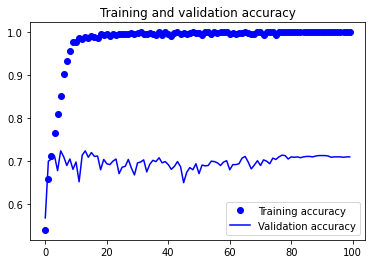

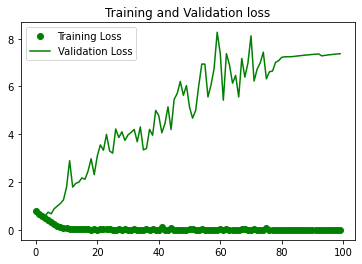

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc,'bo', label ='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'go',label='Training Loss')
plt.plot(epochs, val_loss ,'g',label = 'Validation Loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [22]:
import numpy as np
from google.colab import files 
from keras.preprocessing import image

uploaded= files.upload()

for fn in uploaded.keys():

  path ='/content/' + fn
  img = image.load_img(path,target_size = (150,150))
  x = image.img_to_array(img)
  x= np.expand_dims(x, axis = 0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size = 10)

  print(classes[0])

  if classes[0]>0:
    print(fn + "is a dog")

  else :
    print(fn + "is a cat")

Saving cat.4017.jpg to cat.4017.jpg
[0.]
cat.4017.jpgis a cat
